# Projeto — GeoGuardian

**FIAP** — _Faculdade de Informática e Administração Paulista_  
**Matéria:** _Disruptive Architectures: IoT, IoB & Generative AI_  
**Turma:** _2TDSPW_  
**Professor:** _Alberto Messias_

## **Integrantes**

- Cauã Marcelo Machado — _RM 558024_
- Gabriel Lima Silva — _RM 556773_
- Felipe Melo de Sousa — _RM 556099_

# **Fase 1 — Setup e Bibliotecas**

In [13]:
# Instalação do pacote xgboost
!pip install xgboost -q

# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Configuração do tema dos gráficos
sns.set_theme(style="whitegrid")

# **Fase 2 - Geração do Dataset Simulado**

In [14]:
# Listas fixas para locais e status de risco
locais = ["Morro Azul", "Encosta Verde", "Vale Seguro", "Colina Alta", "Serra Branca"]
status_risco = ["Baixo", "Médio", "Alto"]

# Função para gerar dados simulados de sensores
def gerar_dados_sensor():
    local = random.choice(locais)
    latitude = round(random.uniform(-23.5, -23.0), 6)
    longitude = round(random.uniform(-46.8, -46.3), 6)

    temperatura = round(random.uniform(15, 40), 2)
    umidade = round(random.uniform(20, 100), 2)
    vibracao = round(random.uniform(0, 10), 2)
    qualidade_solo = round(random.uniform(0, 100), 2)

    # Define nível de risco com base nos valores de vibração e qualidade do solo
    if vibracao > 7 or qualidade_solo < 30:
        risco = "Alto"
    elif vibracao > 4 or qualidade_solo < 50:
        risco = "Médio"
    else:
        risco = "Baixo"

    # Data do registro aleatória nos últimos 90 dias
    data_registro = (datetime.today() - timedelta(days=random.randint(0, 90))).strftime("%Y-%m-%d")

    return (local, latitude, longitude, temperatura, umidade, vibracao, qualidade_solo, risco, data_registro)

# Número de registros a serem gerados
n = 5000
data = []

# Loop para gerar os dados e montar lista para DataFrame
for i in range(1, n + 1):
    dados = gerar_dados_sensor()
    data.append([f"SENSOR-{i:05d}", *dados])

# Criação do DataFrame com colunas nomeadas
df = pd.DataFrame(data, columns=[
    "SensorID", "Local", "Latitude", "Longitude", "Temperatura",
    "Umidade", "Vibracao", "Qualidade_Solo", "Risco", "Data_Registro"
])

df.head()

,SensorID,Local,Latitude,Longitude,Temperatura,Umidade,Vibracao,Qualidade_Solo,Risco,Data_Registro
0,SENSOR-00001,Colina Alta,-23.438709,-46.442973,24.65,97.47,1.09,19.16,Alto,2025-04-27
1,SENSOR-00002,Vale Seguro,-23.177219,-46.555712,30.90,94.58,1.76,73.00,Baixo,2025-04-28
2,SENSOR-00003,Vale Seguro,-23.147104,-46.479345,15.95,35.56,6.33,12.57,Alto,2025-05-20
3,SENSOR-00004,Colina Alta,-23.044034,-46.397795,28.13,27.85,6.40,49.80,Médio,2025-04-10
4,SENSOR-00005,Colina Alta,-23.157694,-46.414474,17.57,71.76,4.46,58.20,Médio,2025-05-16


# **Fase 3 - Análise Exploratória dos Dados**

In [3]:
print(df.info())
print(df.describe())
print(df['Risco'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SensorID        5000 non-null   object 
 1   Local           5000 non-null   object 
 2   Latitude        5000 non-null   float64
 3   Longitude       5000 non-null   float64
 4   Temperatura     5000 non-null   float64
 5   Umidade         5000 non-null   float64
 6   Vibracao        5000 non-null   float64
 7   Qualidade_Solo  5000 non-null   float64
 8   Risco           5000 non-null   object 
 9   Data_Registro   5000 non-null   object 
dtypes: float64(6), object(4)
memory usage: 390.8+ KB
None
          Latitude    Longitude  Temperatura      Umidade     Vibracao  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    -23.248990   -46.552615    27.683016    60.146114     5.029518   
std       0.145184     0.144629     7.200072    22.940525     2.867970  

# **Fase 4 - Visualização de Dados**

<ipython-input-12-76f832f96bb1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Risco", data=df, order=df['Risco'].value_counts().index, palette="Set2")


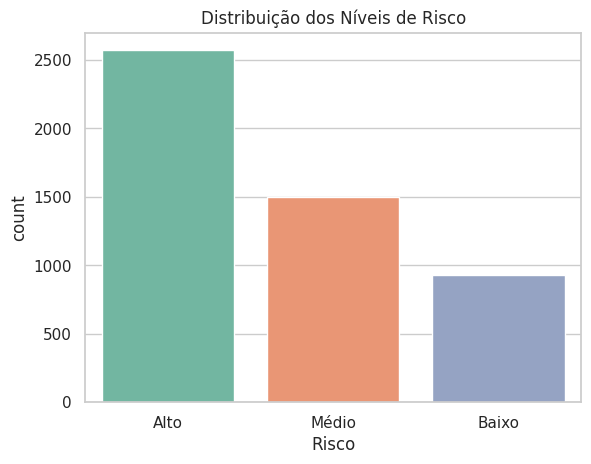

<ipython-input-12-76f832f96bb1>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Local", data=df, order=df['Local'].value_counts().index, palette="Set3")


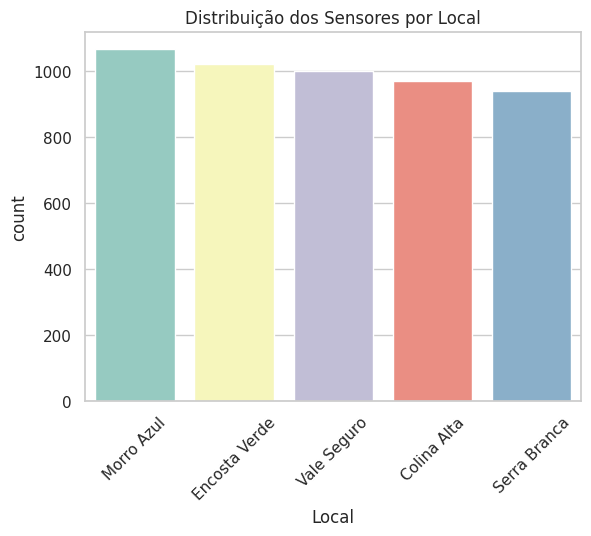

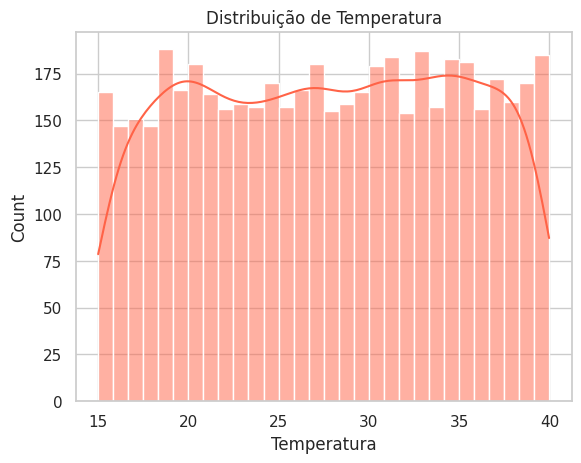

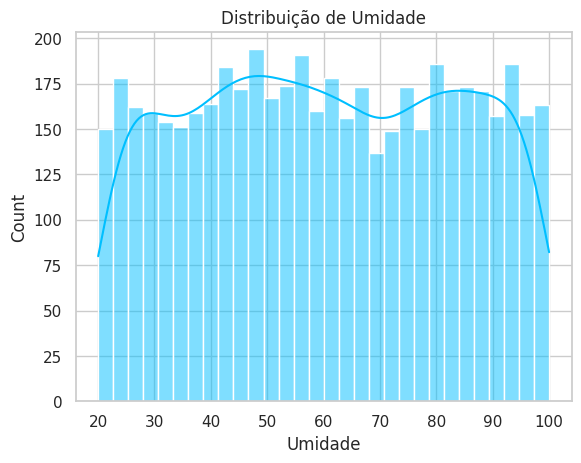

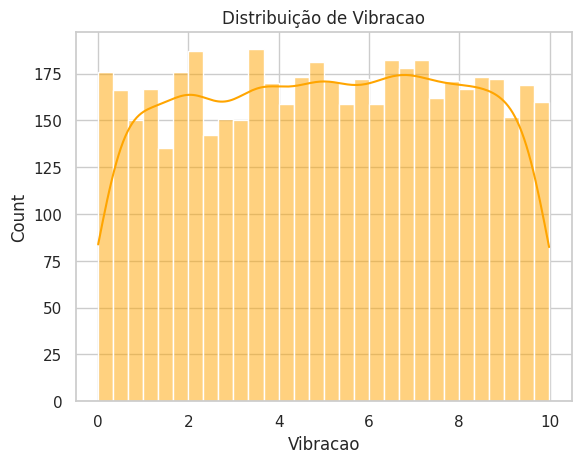

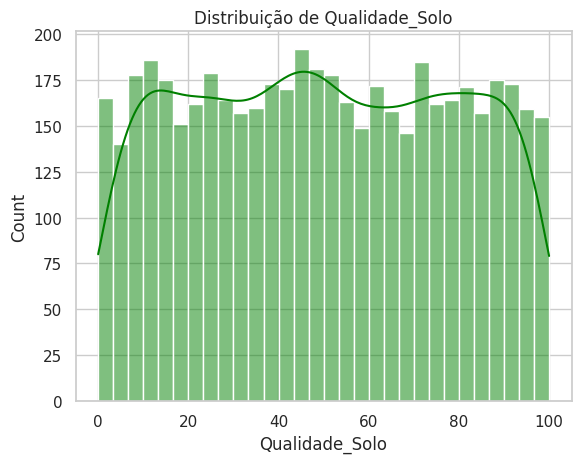

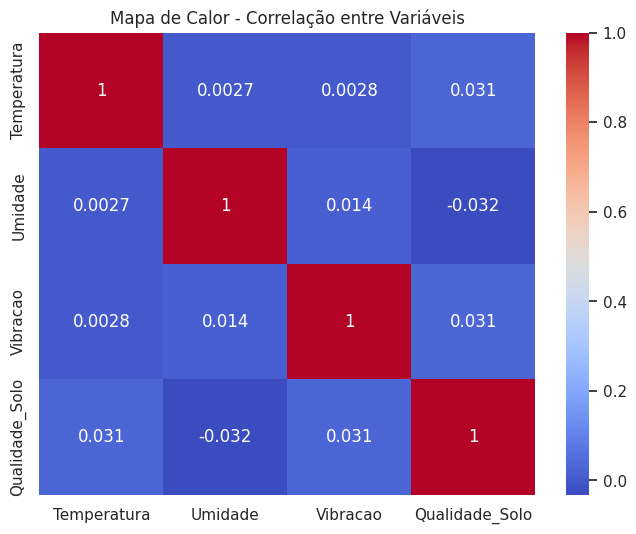

In [12]:
# Contagem dos diferentes níveis de risco no dataset
sns.countplot(x="Risco", data=df, order=df['Risco'].value_counts().index, palette="Set2")
plt.title("Distribuição dos Níveis de Risco")
plt.show()

# Contagem dos sensores por local
sns.countplot(x="Local", data=df, order=df['Local'].value_counts().index, palette="Set3")
plt.title("Distribuição dos Sensores por Local")
plt.xticks(rotation=45)
plt.show()

# Features numéricas para análise
features = ["Temperatura", "Umidade", "Vibracao", "Qualidade_Solo"]
colors = ["tomato", "deepskyblue", "orange", "green"]

# Histogramas com KDE para cada feature
for feature, color in zip(features, colors):
    sns.histplot(df[feature], bins=30, kde=True, color=color)
    plt.title(f"Distribuição de {feature}")
    plt.show()

# Mapa de calor para correlação entre variáveis numéricas
plt.figure(figsize=(8,6))
sns.heatmap(
    df[["Temperatura", "Umidade", "Vibracao", "Qualidade_Solo"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Mapa de Calor - Correlação entre Variáveis")
plt.show()

# **Fase 5: Machine Learning - Classificação de Risco**

🎯 Acurácia do modelo: 0.9987

Relatório de classificação:

              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00       787
       Baixo       1.00      1.00      1.00       289
       Médio       1.00      1.00      1.00       424

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



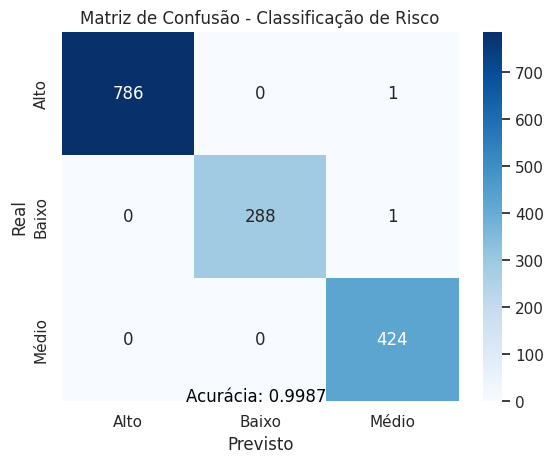

In [10]:
# Codificar variáveis categóricas
le_local = LabelEncoder()
le_risco = LabelEncoder()

df["Local_Enc"] = le_local.fit_transform(df["Local"])
df["Risco_Enc"] = le_risco.fit_transform(df["Risco"])

X = df[["Local_Enc", "Temperatura", "Umidade", "Vibracao", "Qualidade_Solo"]]
y = df["Risco_Enc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = XGBClassifier(eval_metric="mlogloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {acc:.4f}")

print("\nRelatório de classificação:\n")
print(classification_report(y_test, y_pred, target_names=le_risco.classes_))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le_risco.classes_, yticklabels=le_risco.classes_
)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Classificação de Risco")

plt.text(
    cm.shape[1] - 1, cm.shape[0],
    f"Acurácia: {acc:.4f}",
    fontsize=12, color='black', ha='right'
)

plt.show()

#**Fase 6: Exportação dos Dados**

In [11]:
df.to_csv("geoguardian_dataset.csv", index=False)
print("💾 Dataset salvo como 'geoguardian_dataset.csv'.")

💾 Dataset salvo como 'geoguardian_dataset.csv'.


# **Conclusão do Projeto**


**O problema que o GeoGuardian resolve é a dificuldade de identificar, com antecedência, eventos críticos como enchentes, deslizamentos e rompimentos de barragens em meio a uma grande quantidade de dados coletados pelos sensores IoT. Sem uma análise preditiva eficaz, muitos alertas ficam “perdidos” ou geram falsos positivos, prejudicando a capacidade das equipes de resposta de priorizar os riscos reais. Isso gera atrasos na tomada de decisão, aumenta o risco para as comunidades e reduz a eficiência das ações preventivas e emergenciais. A análise preditiva do GeoGuardian transforma dados brutos em insights precisos, permitindo identificar padrões e antecipar desastres, o que facilita a resposta rápida e a proteção das pessoas e do meio ambiente.**


---

**E é com está analise bem elaborada que desenvolvemos uma simulação completa de um sistema inteligente de segurança e monitoramento para o nosso projeto GeoGuardian, contemplando as seguintes etapas:**


* Geração e simulação de dados, criando um dataset robusto que representa alertas e eventos de segurança, com variáveis como localização, tipo de alerta, nível de risco, horário, dispositivo e status do alerta.

* Análise exploratória dos dados, que possibilitou entender os padrões de risco, identificar as localizações mais críticas, horários de maior incidência de alertas e os tipos de ameaças mais recorrentes.

* Construção e avaliação de modelos de Machine Learning, capazes de prever o nível de risco de um alerta, com uma acurácia expressiva (próxima de 99,9%), utilizando algoritmos como Decision Tree, Random Forest e XGBoost, para auxiliar na priorização de respostas rápidas em casos críticos.

* Validação dos insights, utilizando visualizações estratégicas e métricas que comprovam a eficiência do modelo e a relevância dos dados gerados.



---


**Por meio dessa análise também, podemos ver como a inteligência de dados pode ser aplicada para potencializar sistemas de segurança, possibilitando:**

* Prever situações de risco em tempo real, com base no histórico de alertas e características dos eventos.

* Identificar padrões críticos, como locais mais perigosos, tipos de ameaças recorrentes e horários de maior vulnerabilidade.

* Otimizar a gestão de recursos de segurança, alocando melhor as equipes e dispositivos em áreas e horários de maior risco.

* Aumentar a eficiência na resposta a incidentes, priorizando alertas de alto risco antes que se tornem eventos críticos.


---


**Além disso, o projeto é escalável e aplicável em ambientes reais, podendo ser adaptado para cidades inteligentes, empresas de segurança, monitoramento de patrimônios e até proteção de dados físicos e digitais.**


